In [1]:
import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
from IPython.display import Image, Math, display, Markdown
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format
plt.rcParams["text.usetex"] = True

In [6]:
tournament_file = "./tournaments/rakuda_v1.jsonl"
charts_prefix = "./charts/" + tournament_file.split("/")[-1].split(".")[0]
with open(tournament_file, "r") as f:
    tournament = json.load(f)

df = pd.DataFrame(tournament["matches"])
df = df[["model1_id", "model2_id", "score"]]
df['score'] = df['score'].map({1: 1, 2: 0, 3: 0.5})

df.sample(5)  # score 1 -> model 1 victory, 0 -> model 2 victory, 0.5 -> draw

,model1_id,model2_id,score
391,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,rinna/japanese-gpt-neox-3.6b,1.000
682,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,rinna/japanese-gpt-neox-3.6b-instruction-ppo,1.000
327,rinna/japanese-gpt-neox-3.6b-instruction-ppo,cyberagent/open-calm-7b,1.000
922,izumi-lab/stormy-7b-10ep,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,0.000
850,izumi-lab/stormy-7b-10ep,gpt-3.5-turbo-0301:20230614,0.000


##  Defining useful data quantities

In [7]:
# A mapping from a model to an integer index for convenience
model_to_int = {
    x: i
    for i, x in enumerate(
        df.groupby(["model1_id", "model2_id"]).size().unstack(fill_value=0).index
    )
}

int_to_model = {integer: model for model, integer in model_to_int.items()}
int_to_model

{0: 'cyberagent/open-calm-7b',
 1: 'gpt-3.5-turbo-0301:20230614',
 2: 'izumi-lab/stormy-7b-10ep',
 3: 'rinna/japanese-gpt-neox-3.6b',
 4: 'rinna/japanese-gpt-neox-3.6b-instruction-ppo',
 5: 'rinna/japanese-gpt-neox-3.6b-instruction-sft-v2'}

In [8]:
# Number of models
N = len(int_to_model)
# Number of matches
M = len(df)

print(f"{N} models played {M} matches")

6 models played 1200 matches


In [9]:
# For display purposes it's helpful to have a short version of the model names
short_names = {}
for name in [int_to_model[i] for i in range(N)]:
    if "gpt-3.5" in name:
        short_name = "gpt-3.5"
    elif "open-calm-7b" in name:
        short_name = "open-calm-7b"
    elif "stormy" in name:
        short_name = "stormy-7b"
    elif "instruction-ppo" in name:
        short_name = "rinna-3.6b-PPO"
    elif "instruction-sft" in name:
        short_name = "rinna-3.6b-SFT"
    elif "neox-3.6b" in name:
        short_name = "rinna-3.6b"
    else:
        short_name = name
    short_names[name] = short_name
short_names

{'cyberagent/open-calm-7b': 'open-calm-7b',
 'gpt-3.5-turbo-0301:20230614': 'gpt-3.5',
 'izumi-lab/stormy-7b-10ep': 'stormy-7b',
 'rinna/japanese-gpt-neox-3.6b': 'rinna-3.6b',
 'rinna/japanese-gpt-neox-3.6b-instruction-ppo': 'rinna-3.6b-PPO',
 'rinna/japanese-gpt-neox-3.6b-instruction-sft-v2': 'rinna-3.6b-SFT'}

In [12]:
# Score vector
Y_m = df['score'].values  # 1 if i_m beat j_m in the mth game, .5 for a draw, 0 otherwise

# match vectors: who played in the mth match
i_m = df.apply(lambda row: model_to_int[row["model1_id"]], axis=1).values
j_m = df.apply(lambda row: model_to_int[row["model2_id"]], axis=1).values

In [42]:
from collections import Counter

review_distribution = Counter(Y_m)
print(review_distribution)

Counter({0.5: 686, 1.0: 469, 0.0: 45})


In [13]:
# total number of times model i in first position beats model j in second position
a_ij = df[df["score"] == 1].groupby(["model1_id", "model2_id"]).size().unstack(
    fill_value=0
) + 0.5 * df[df["score"] == 0.5].groupby(["model1_id", "model2_id"]).size().unstack(
    fill_value=0
)

# total number of times model i in first position loses to model_j in the second position
b_ij = df[df["score"] == 0].groupby(["model1_id", "model2_id"]).size().unstack(
    fill_value=0
) + 0.5 * df[df["score"] == 0.5].groupby(["model1_id", "model2_id"]).size().unstack(
    fill_value=0
)

# total number of times model i plays model j, regardless of order
n_ij = (a_ij + b_ij.T) + (a_ij + b_ij.T).T

# win fraction of model i against model j, regardless of order
win_frac_ij = (a_ij + b_ij.T) / n_ij

# overall average win rate
w_i = (a_ij + b_ij.T).sum(axis=1) / ((a_ij + b_ij.T) + (a_ij + b_ij.T).T).sum(axis=1)

In [14]:
w_i.sort_values()

model1_id
rinna/japanese-gpt-neox-3.6b                      0.351
rinna/japanese-gpt-neox-3.6b-instruction-sft-v2   0.359
rinna/japanese-gpt-neox-3.6b-instruction-ppo      0.393
izumi-lab/stormy-7b-10ep                          0.439
cyberagent/open-calm-7b                           0.515
gpt-3.5-turbo-0301:20230614                       0.944
dtype: float64

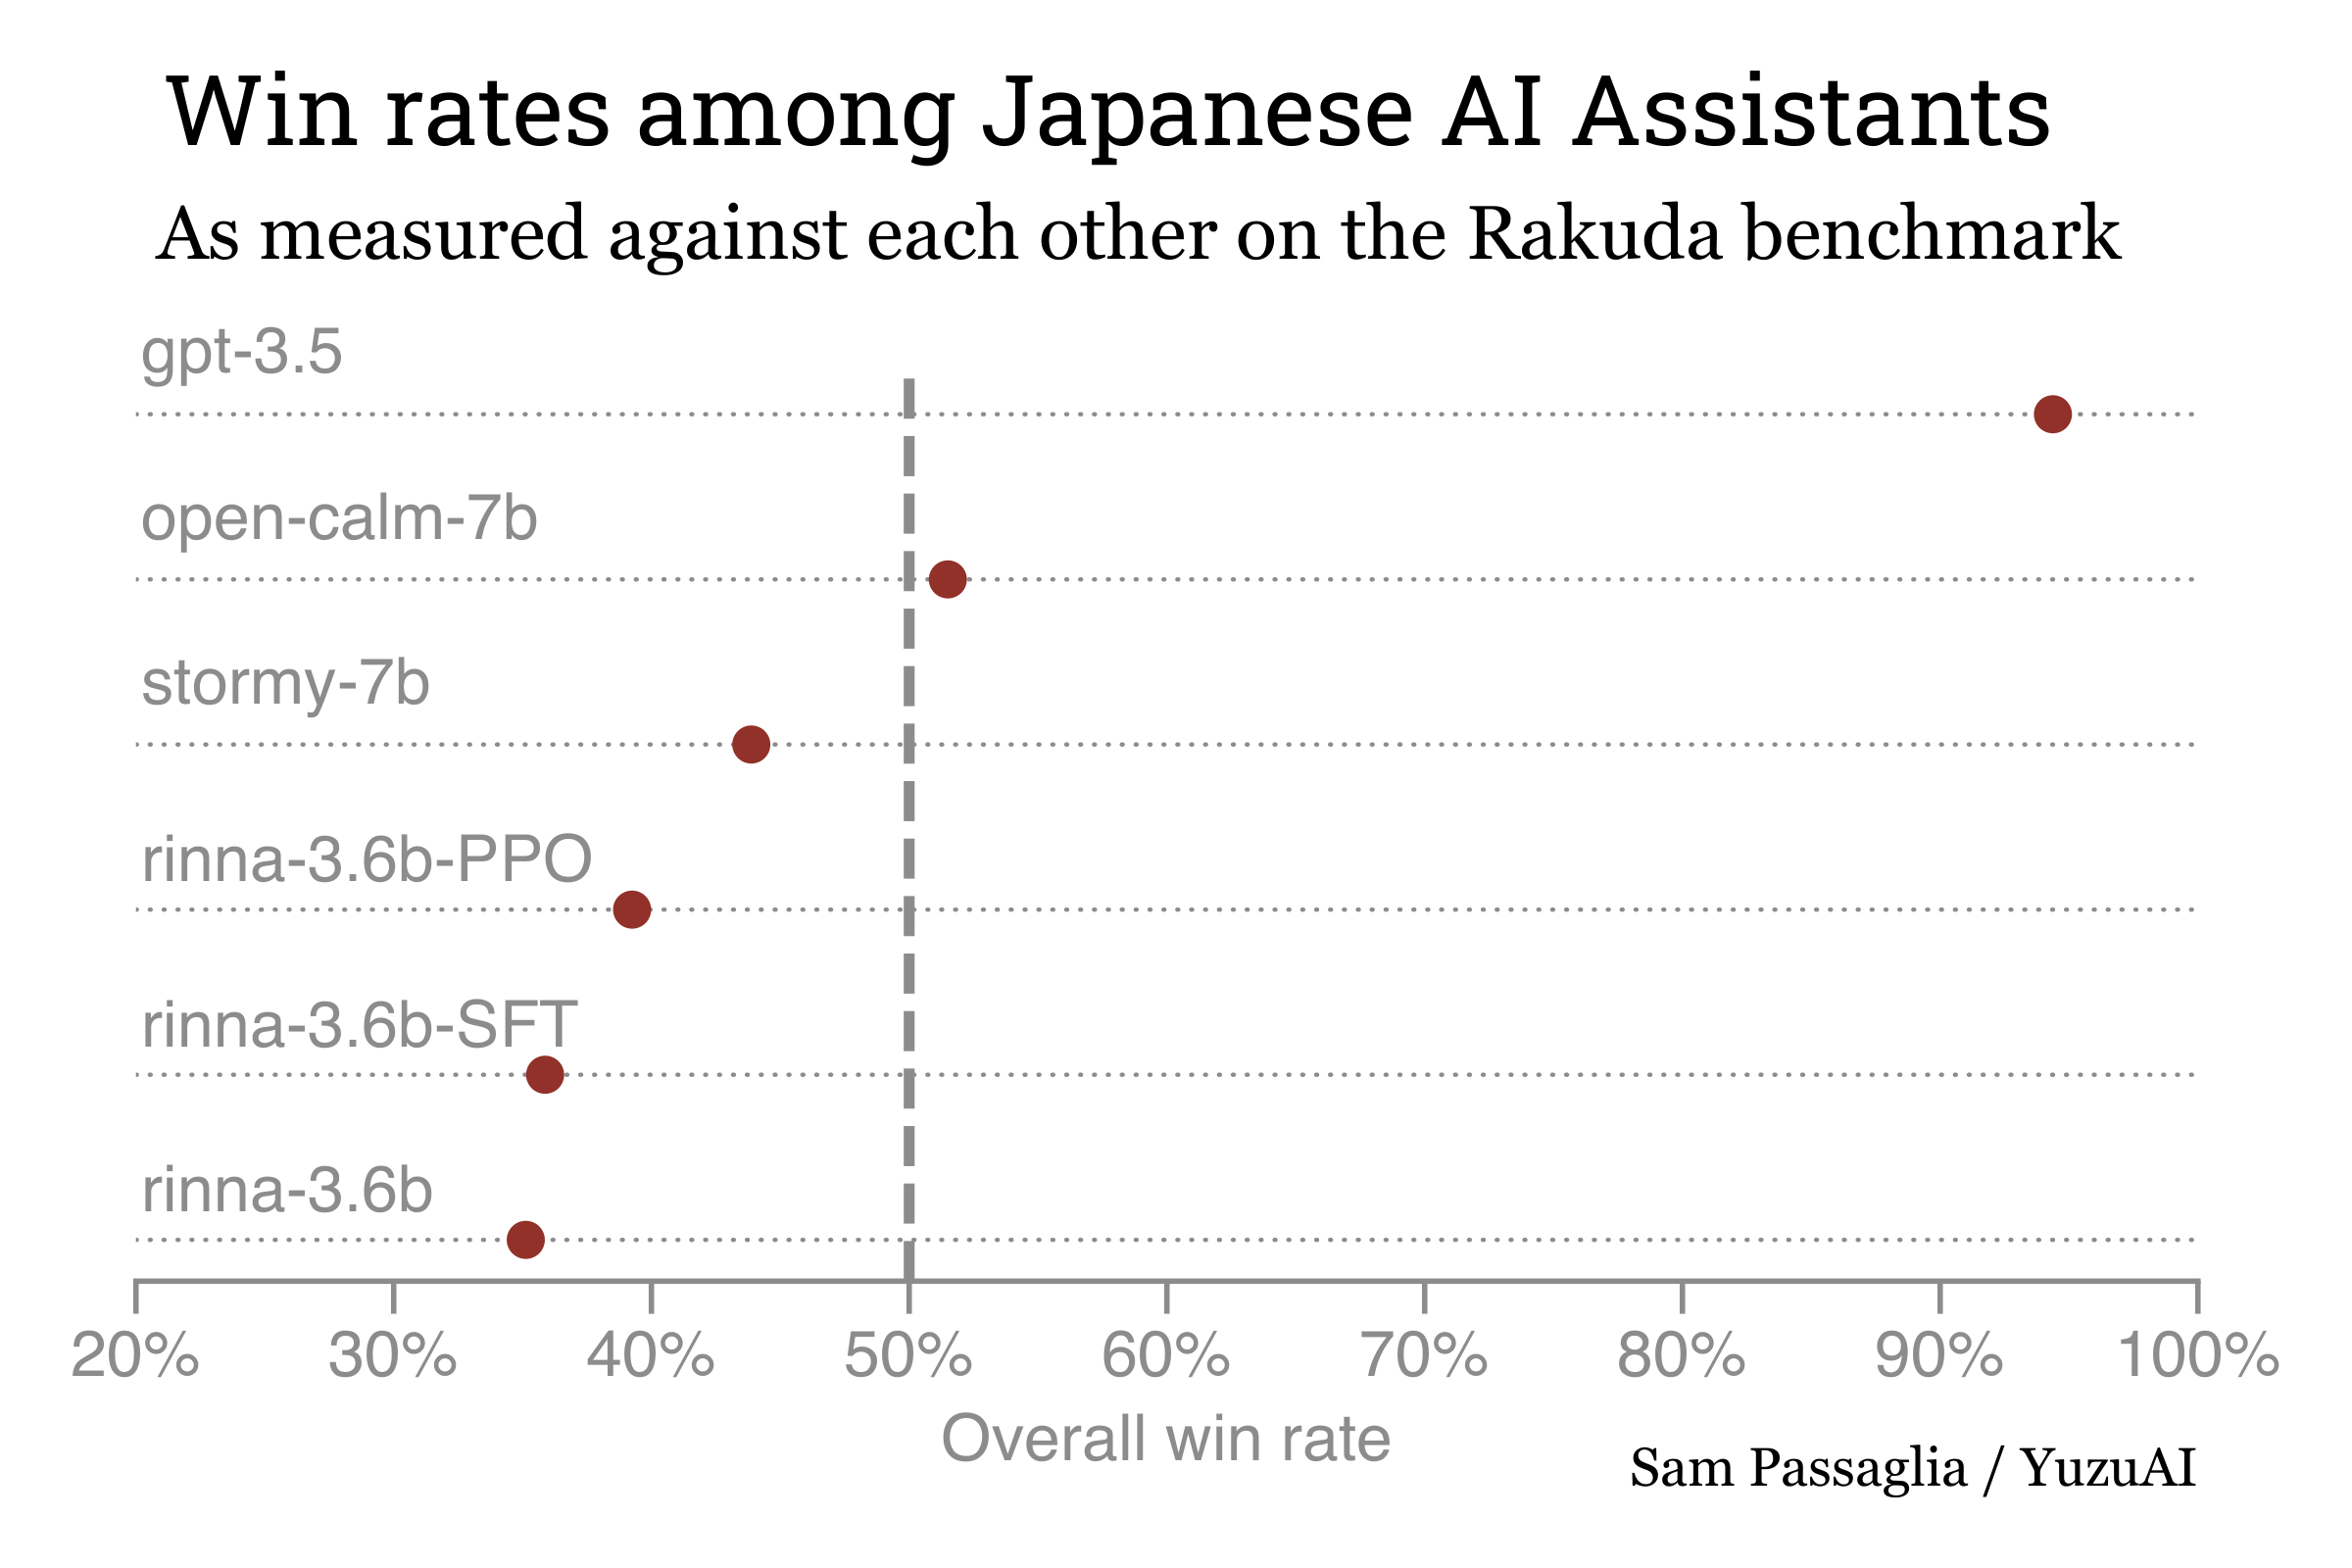

In [15]:
win_rates = w_i.sort_values()

# # Get x values and error values
x_values = win_rates.values
# errors = np.array([[d["one_sigma_down"], d["one_sigma_up"]] for d in strengths]).T
labels = [short_names[model_id] for model_id in win_rates.index]
y_values = range(len(x_values))

# Plot
try:
    from samplotlib import colors
    from samplotlib.circusboy import CircusBoy

    cb = CircusBoy()
    BGColor = "#FFFFFF"
    plt.rcParams["axes.facecolor"] = BGColor
    plt.rcParams["figure.facecolor"] = BGColor
    plt.rcParams["savefig.facecolor"] = BGColor

    fig, ax = cb.handlers()
    cb.set_yTickLabels(ax, yoffset=-3)
    
    ax.scatter(x_values*100, y_values)
    ax.set_xlabel(r"Overall win rate")
    cb.set_byline(ax, "Sam Passaglia / YuzuAI")

    cb.set_title(
        ax,
        title="Win rates among Japanese AI Assistants",
        subtitle="As measured against each other on the Rakuda benchmark",
    )
    ax.set_xlim([20, 100])
    
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    ax.axvline(50, color=cb.grey, ls='--', lw=2)
    #ax.set_ylim([-0.19, 5.3])
    
    ax.set_yticks(y_values, labels)
    #ax.set_xticks([-0.5, 0, 0.5, 1])

    fig.savefig(charts_prefix + "winrate.png")
    fig.savefig(charts_prefix + "winrate.pdf")
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["text.usetex"] = True

except ImportError:
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values)
    plt.xlabel("Overall win rate")
    plt.yticks(y_values, labels)
    plt.savefig(charts_prefix + "winrate.png")
    # plt.show()

Image(charts_prefix + "winrate.png", width=800)

## Modeling strengths with the Bradley-Terry model

We might not always be in the situation where all models face the same set of opponents.
In that case we want a more robust model for our data.

We model the probability that model $i$ in the first position beats model $j$ in the second position as 

$p_{ij} = \dfrac{e^{\alpha+\beta_i - \beta_j}}{1+e^{\alpha+\beta_i-\beta_j}}$

where $\beta_i$ is the strength of model $i$ and $\alpha$ is a home field advantage parameter that is greater than 0 if the model in the first position is favored over the model in the second position and is less than 0 if the second model is favored. Draws are counted as a half-win for each teams.

In [16]:
def p(alpha, beta_i, beta_j):
    return np.exp(alpha + beta_i - beta_j) / (1 + np.exp(alpha + beta_i - beta_j))

The log likelihood of the data given the parameters is then [given by](https://web.stanford.edu/class/archive/stats/stats200/stats200.1172/Lecture24.pdf)

In [17]:
def l(alpha, betas, Y_m, i_m, j_m):
    betas_diff = betas[i_m] - betas[j_m]
    return np.sum(Y_m * (alpha + betas_diff) - np.log1p(np.exp(alpha + betas_diff)))

## Find the point in parameter space that maximizes the likelihood using scipy.optimize

In [18]:
from scipy.optimize import minimize

# Initial guess for the parameters
x0 = np.zeros(N + 1)

# Define the system of equations
def F(x):
    return -l(x[0], x[1:], Y_m, i_m, j_m) + (
        1000 * np.sum(x[1:]) ** 2
    )  # term to enforce sum of betas is ~0


max_likelihood = minimize(F, x0, method="Nelder-Mead", options={"maxiter": 10000})
print(f"Maximum Likelihood Solution is {max_likelihood}")
print(f"Beta sum: {np.sum(max_likelihood.x[1:])}")

Maximum Likelihood Solution is  final_simplex: (array([[-0.50927137, -0.09938389,  2.50008673, -0.38301003, -0.76519799,
        -0.58012501, -0.66850161],
       [-0.50932604, -0.09941829,  2.50011711, -0.38293604, -0.76523406,
        -0.58014383, -0.66851829],
       [-0.50931006, -0.09941366,  2.50017086, -0.38307972, -0.76517993,
        -0.58011398, -0.66851378],
       [-0.50929582, -0.09941026,  2.50018638, -0.38298365, -0.76521738,
        -0.58017135, -0.66853733],
       [-0.50929629, -0.09936851,  2.50000449, -0.38296569, -0.76519327,
        -0.58014414, -0.66846413],
       [-0.50931919, -0.09938716,  2.50015735, -0.38301151, -0.7651979 ,
        -0.58015674, -0.6685218 ],
       [-0.50932893, -0.09941159,  2.50016833, -0.3830556 , -0.765161  ,
        -0.58018408, -0.66849264],
       [-0.50930144, -0.09937158,  2.5001823 , -0.3830335 , -0.76525513,
        -0.58013003, -0.66852201]]), array([599.38994524, 599.38994526, 599.38994533, 599.38994534,
       599.3899454 , 59

## Use the maximum likelihood parameters to initialize an MCMC

In [19]:
import emcee

# Parameter space dimension
ndim = N + 1

# Number of independent chains
nwalkers = 32

# Number of samples per chain
nsamples = 60000

# Prior is what we knew before running the experiment
def log_prior(x):
    if (
        -3 < x[0] < 3
        and all([-3 < beta < 3 for beta in x[1:]])
        and sum(x[1:]) ** 2 < 0.1
    ):
        return 0.0
    return -np.inf


# Log Probability = Log_Prior + Log Likelihood
def log_probability(x):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + l(x[0], x[1:], Y_m, i_m, j_m) - 1000 * np.sum(x[1:]) ** 2


# Initialize the walkers randomly around the MLE point
p0 = np.random.normal(max_likelihood.x, 0.05, (nwalkers, ndim))

# Define the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Run the MCMC
# this doesn't take more than ~ 1 minute to run.
# if too slow reduce nsamples or nwalkers, default numbers are overkill
sampler.run_mcmc(p0, nsamples);

In [20]:
print("Mean acceptance fraction: {0:.2f}".format(np.mean(sampler.acceptance_fraction)))
print(
    "Mean autocorrelation time: {0:.0f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.49
Mean autocorrelation time: 81 steps


In [21]:
# Burn the first 1000 steps per chain to erase initial conditions
flat_samples = sampler.get_chain(discard=1000, flat=True)
thin_samples = sampler.get_chain(discard=1000, thin=25, flat=True)

print(flat_samples.shape)
print(thin_samples.shape)

(1888000, 7)
(75520, 7)


In [22]:
parameter_labels = [rf"\alpha"] + [
    rf"\beta_{{\textrm{{{label}}}}}" for label in short_names.values()
]
parameter_labels_with_dollar = [
    rf"${parameter_label}$" for parameter_label in parameter_labels
]

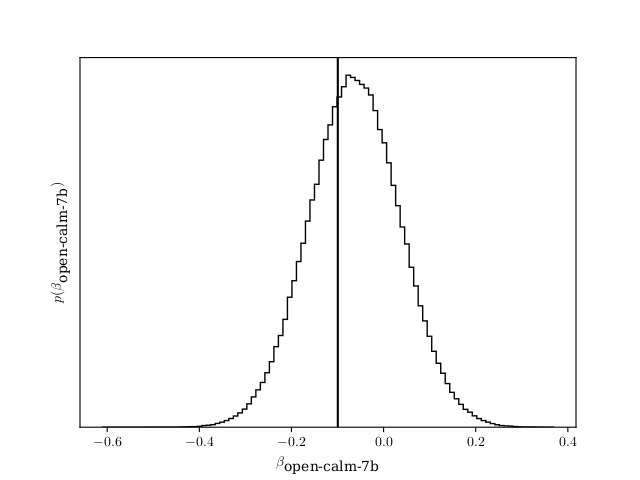

In [23]:
# Plot a parameter distribution

parameter_index = 1

plt.close("all")
plt.hist(
    flat_samples[:, parameter_index],
    100,
    color="k",
    histtype="step",
    label="Posterior Samples",
)
plt.axvline(max_likelihood.x[parameter_index], color="k", label="MLE result")

plt.xlabel(parameter_labels_with_dollar[parameter_index])
plt.ylabel(rf"$p({parameter_labels[parameter_index]})$")
plt.gca().set_yticks([])
plt.savefig(charts_prefix + "parameter.png")
plt.legend()

# If using a non-interactive matplotlib back-end
Image(charts_prefix + "parameter.png", width=800)

In [41]:
parameters = []
betasum = 0
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    # print(mcmc[1], max_likelihood.x[i])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], parameter_labels[i])
    display(Math(txt))

    parameter_name = (["alpha"] + [int_to_model[i] for i in range(N)])[i]
    short_name = (["alpha"] + list(short_names.values()))[i]
    
    parameter_dict = {
            "parameter": parameter_name,
            "short_name": short_name,
            "median": mcmc[1],
            "one_sigma_down": q[0],
            "one_sigma_up": q[1],
        }
    
    if i > 0:
        betasum += mcmc[1]
        parameter_dict['win_rate'] = win_rates[parameter_name]
    parameters.append(parameter_dict
    )


print(f"Sum of betas {betasum}")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Sum of betas -0.0015779360520126184


In [40]:
parameters

[{'parameter': 'alpha',
  'short_name': 'alpha',
  'median': -0.524042910209368,
  'one_sigma_down': 0.07094424887576045,
  'one_sigma_up': 0.07089484647304434},
 {'parameter': 'cyberagent/open-calm-7b',
  'short_name': 'open-calm-7b',
  'median': -0.0629756357117256,
  'one_sigma_down': 0.09811165201903652,
  'one_sigma_up': 0.09829506698284135,
  'win_rate': 0.515},
 {'parameter': 'gpt-3.5-turbo-0301:20230614',
  'short_name': 'gpt-3.5',
  'median': 2.4866494932137533,
  'one_sigma_down': 0.1789867023675713,
  'one_sigma_up': 0.18817438749235516,
  'win_rate': 0.94375},
 {'parameter': 'izumi-lab/stormy-7b-10ep',
  'short_name': 'stormy-7b',
  'median': -0.38388095824887036,
  'one_sigma_down': 0.09835352050045487,
  'one_sigma_up': 0.09745874089596196,
  'win_rate': 0.43875},
 {'parameter': 'rinna/japanese-gpt-neox-3.6b',
  'short_name': 'rinna-3.6b',
  'median': -0.7498557357907184,
  'one_sigma_down': 0.10003286147865575,
  'one_sigma_up': 0.09884518008352816,
  'win_rate': 0.35125

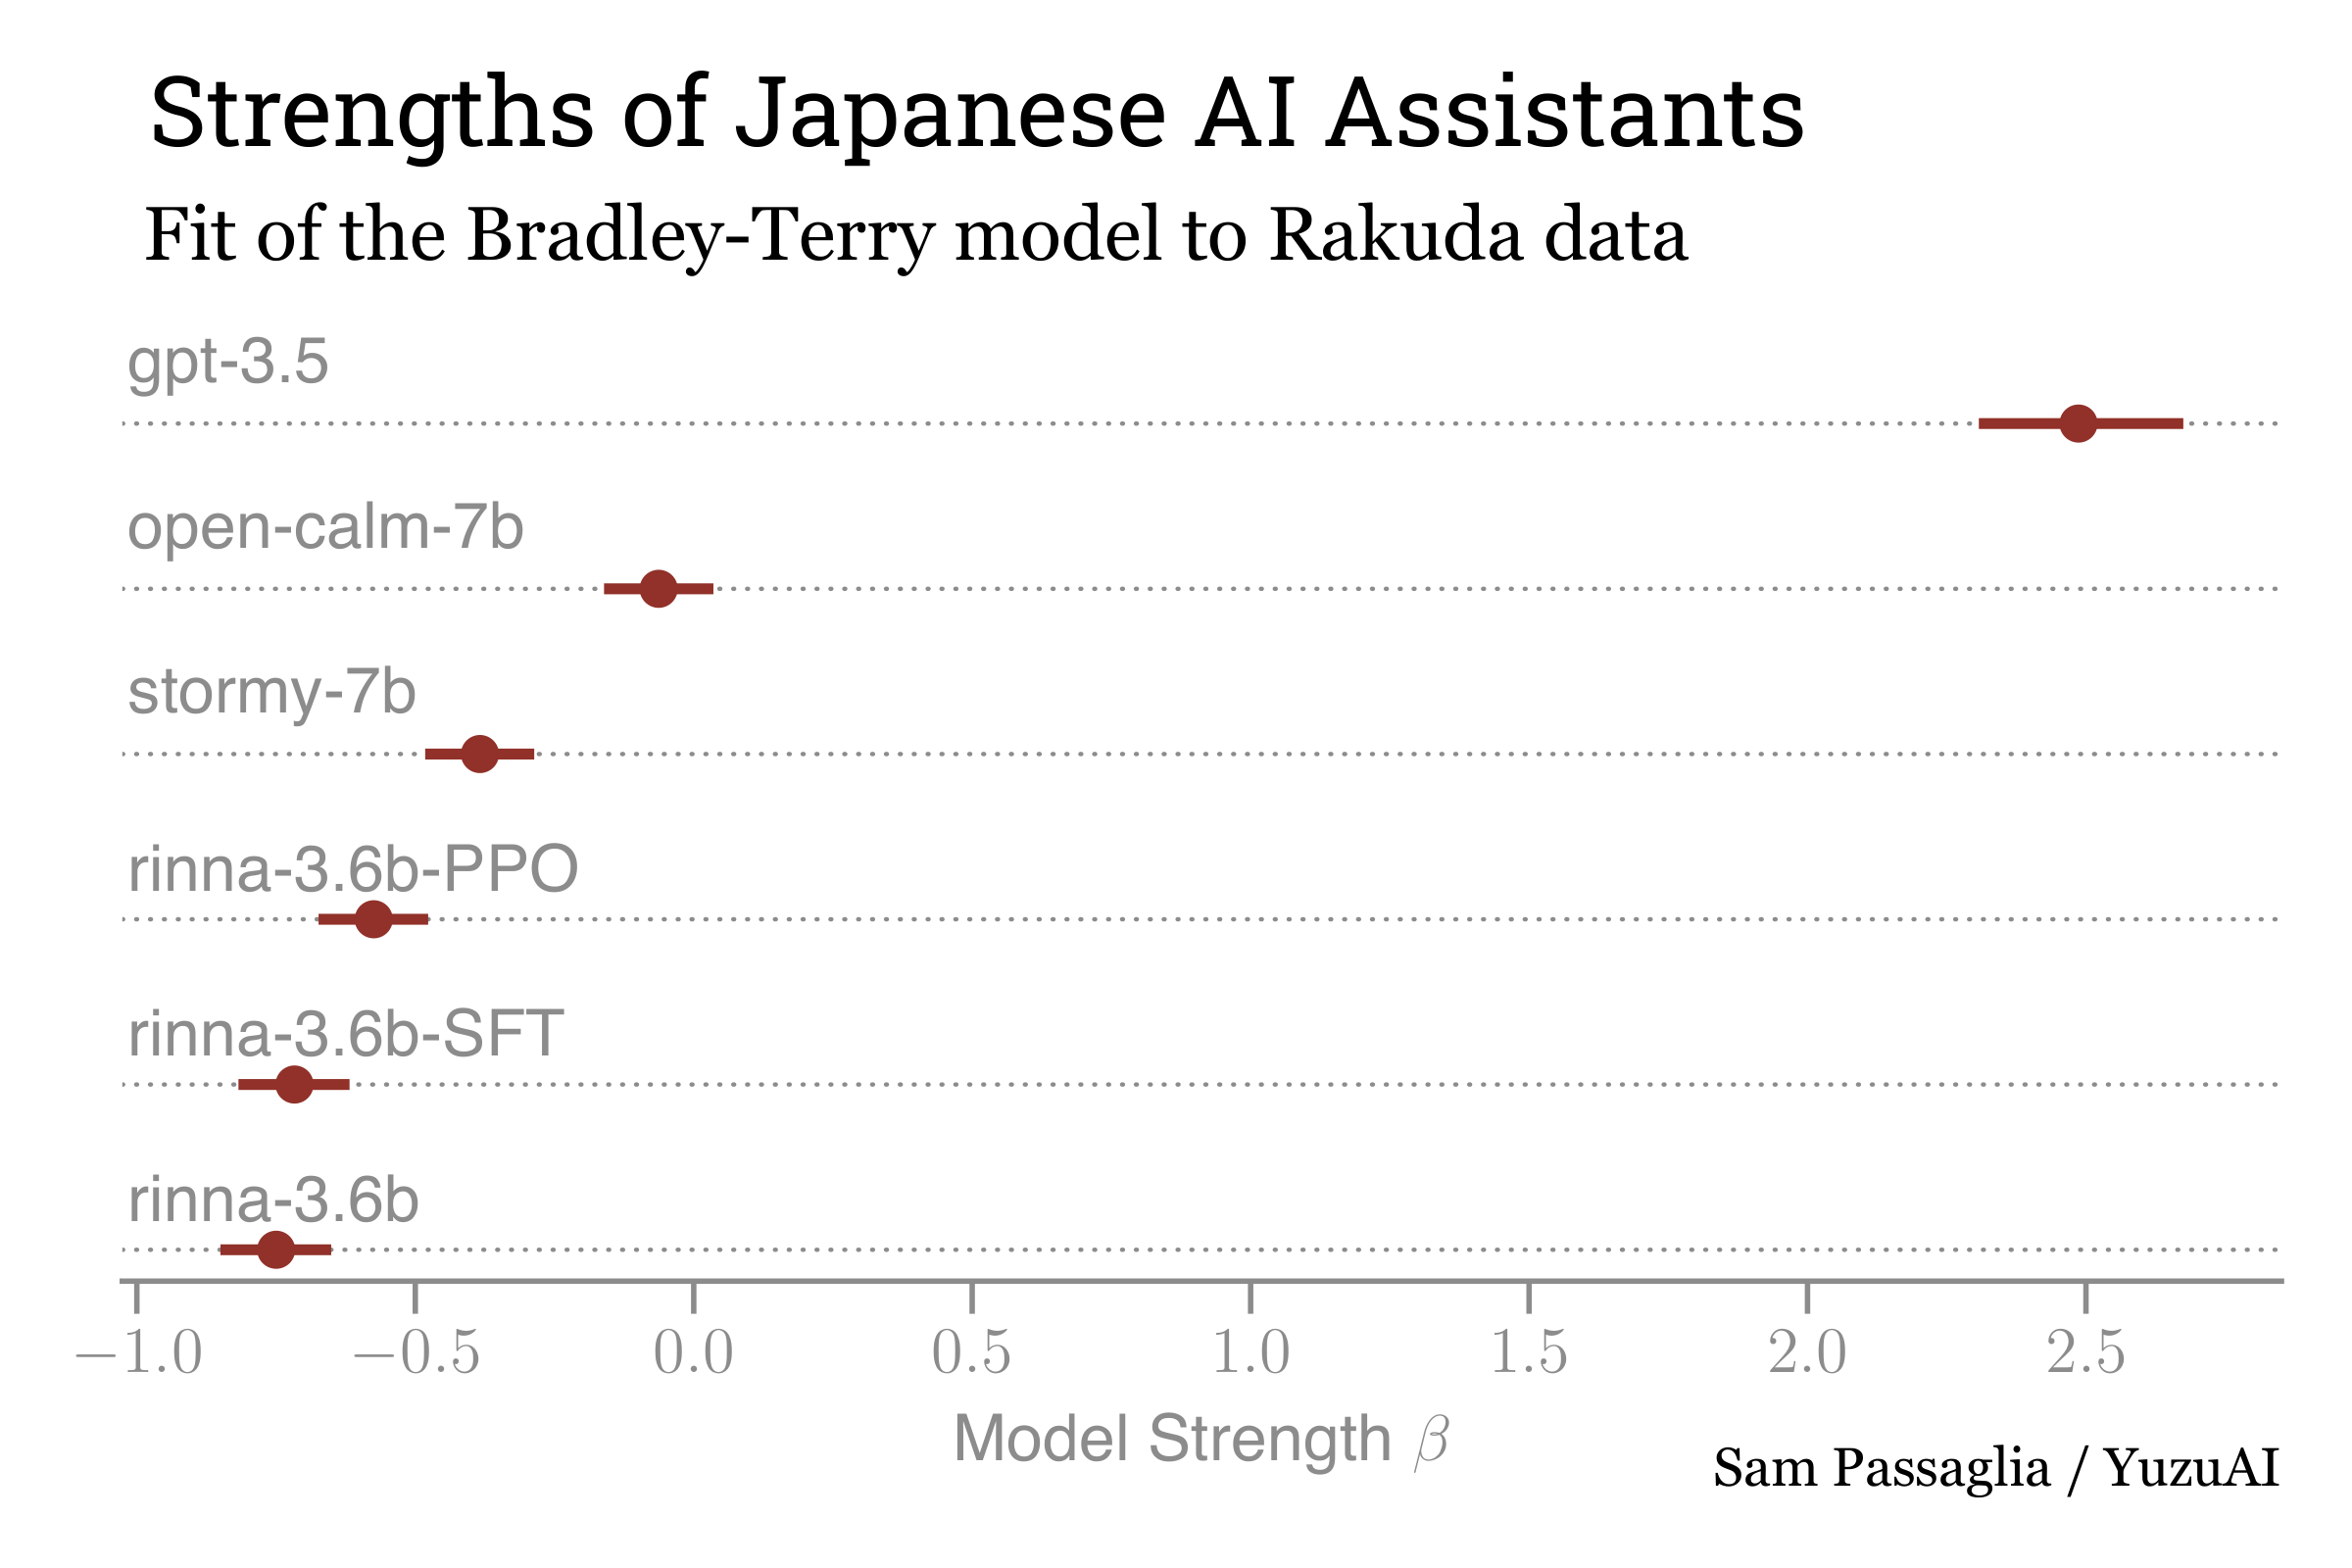

In [26]:
strengths = [
    {("model_id" if k == "parameter" else k): v for k, v in d.items()}
    for d in parameters[1:]
]

# Sort the models by strength
strengths.sort(key=lambda d: d["median"])

# Get x values and error values
x_values = [d["median"] for d in strengths]
errors = np.array([[d["one_sigma_down"], d["one_sigma_up"]] for d in strengths]).T
labels = [d["short_name"] for d in strengths]
y_values = range(len(x_values))

# Plot
try:
    from samplotlib import colors
    from samplotlib.circusboy import CircusBoy

    cb = CircusBoy()
    BGColor = "#FFFFFF"
    plt.rcParams["axes.facecolor"] = BGColor
    plt.rcParams["figure.facecolor"] = BGColor
    plt.rcParams["savefig.facecolor"] = BGColor

    fig, ax = cb.handlers()
    cb.set_yTickLabels(ax, yoffset=-3)
    ax.errorbar(x_values, y_values, xerr=errors, fmt="o")
    ax.set_xlabel(r"Model Strength $\beta$")
    cb.set_byline(ax, "Sam Passaglia / YuzuAI")

    cb.set_title(
        ax,
        title="Strengths of Japanese AI Assistants",
        subtitle="Fit of the Bradley-Terry model to Rakuda data",
    )
    #ax.set_xlim([-0.6, 1.0])
    ax.set_ylim([-0.19, 5.3])
    ax.set_yticks(y_values, labels)
    #ax.set_xticks([-0.5, 0, 0.5, 1])

    fig.savefig(charts_prefix + "ranking.png")
    fig.savefig(charts_prefix + "ranking.pdf")
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["text.usetex"] = True

except ImportError:
    plt.figure(figsize=(10, 6))
    plt.errorbar(x_values, y_values, xerr=errors, fmt="o")
    plt.xlabel("Model Strength")
    plt.yticks(y_values, labels)
    plt.savefig(charts_prefix + "ranking.png")
    # plt.show()

Image(charts_prefix + "ranking.png", width=800)

Note the errors on this chart are correlated. We can calculate statistics for parameter differences (e.g. fraction of samples where model A > model B) 

cyberagent/open-calm-7b is stronger than izumi-lab/stormy-7b-10ep with 98.61% confidence


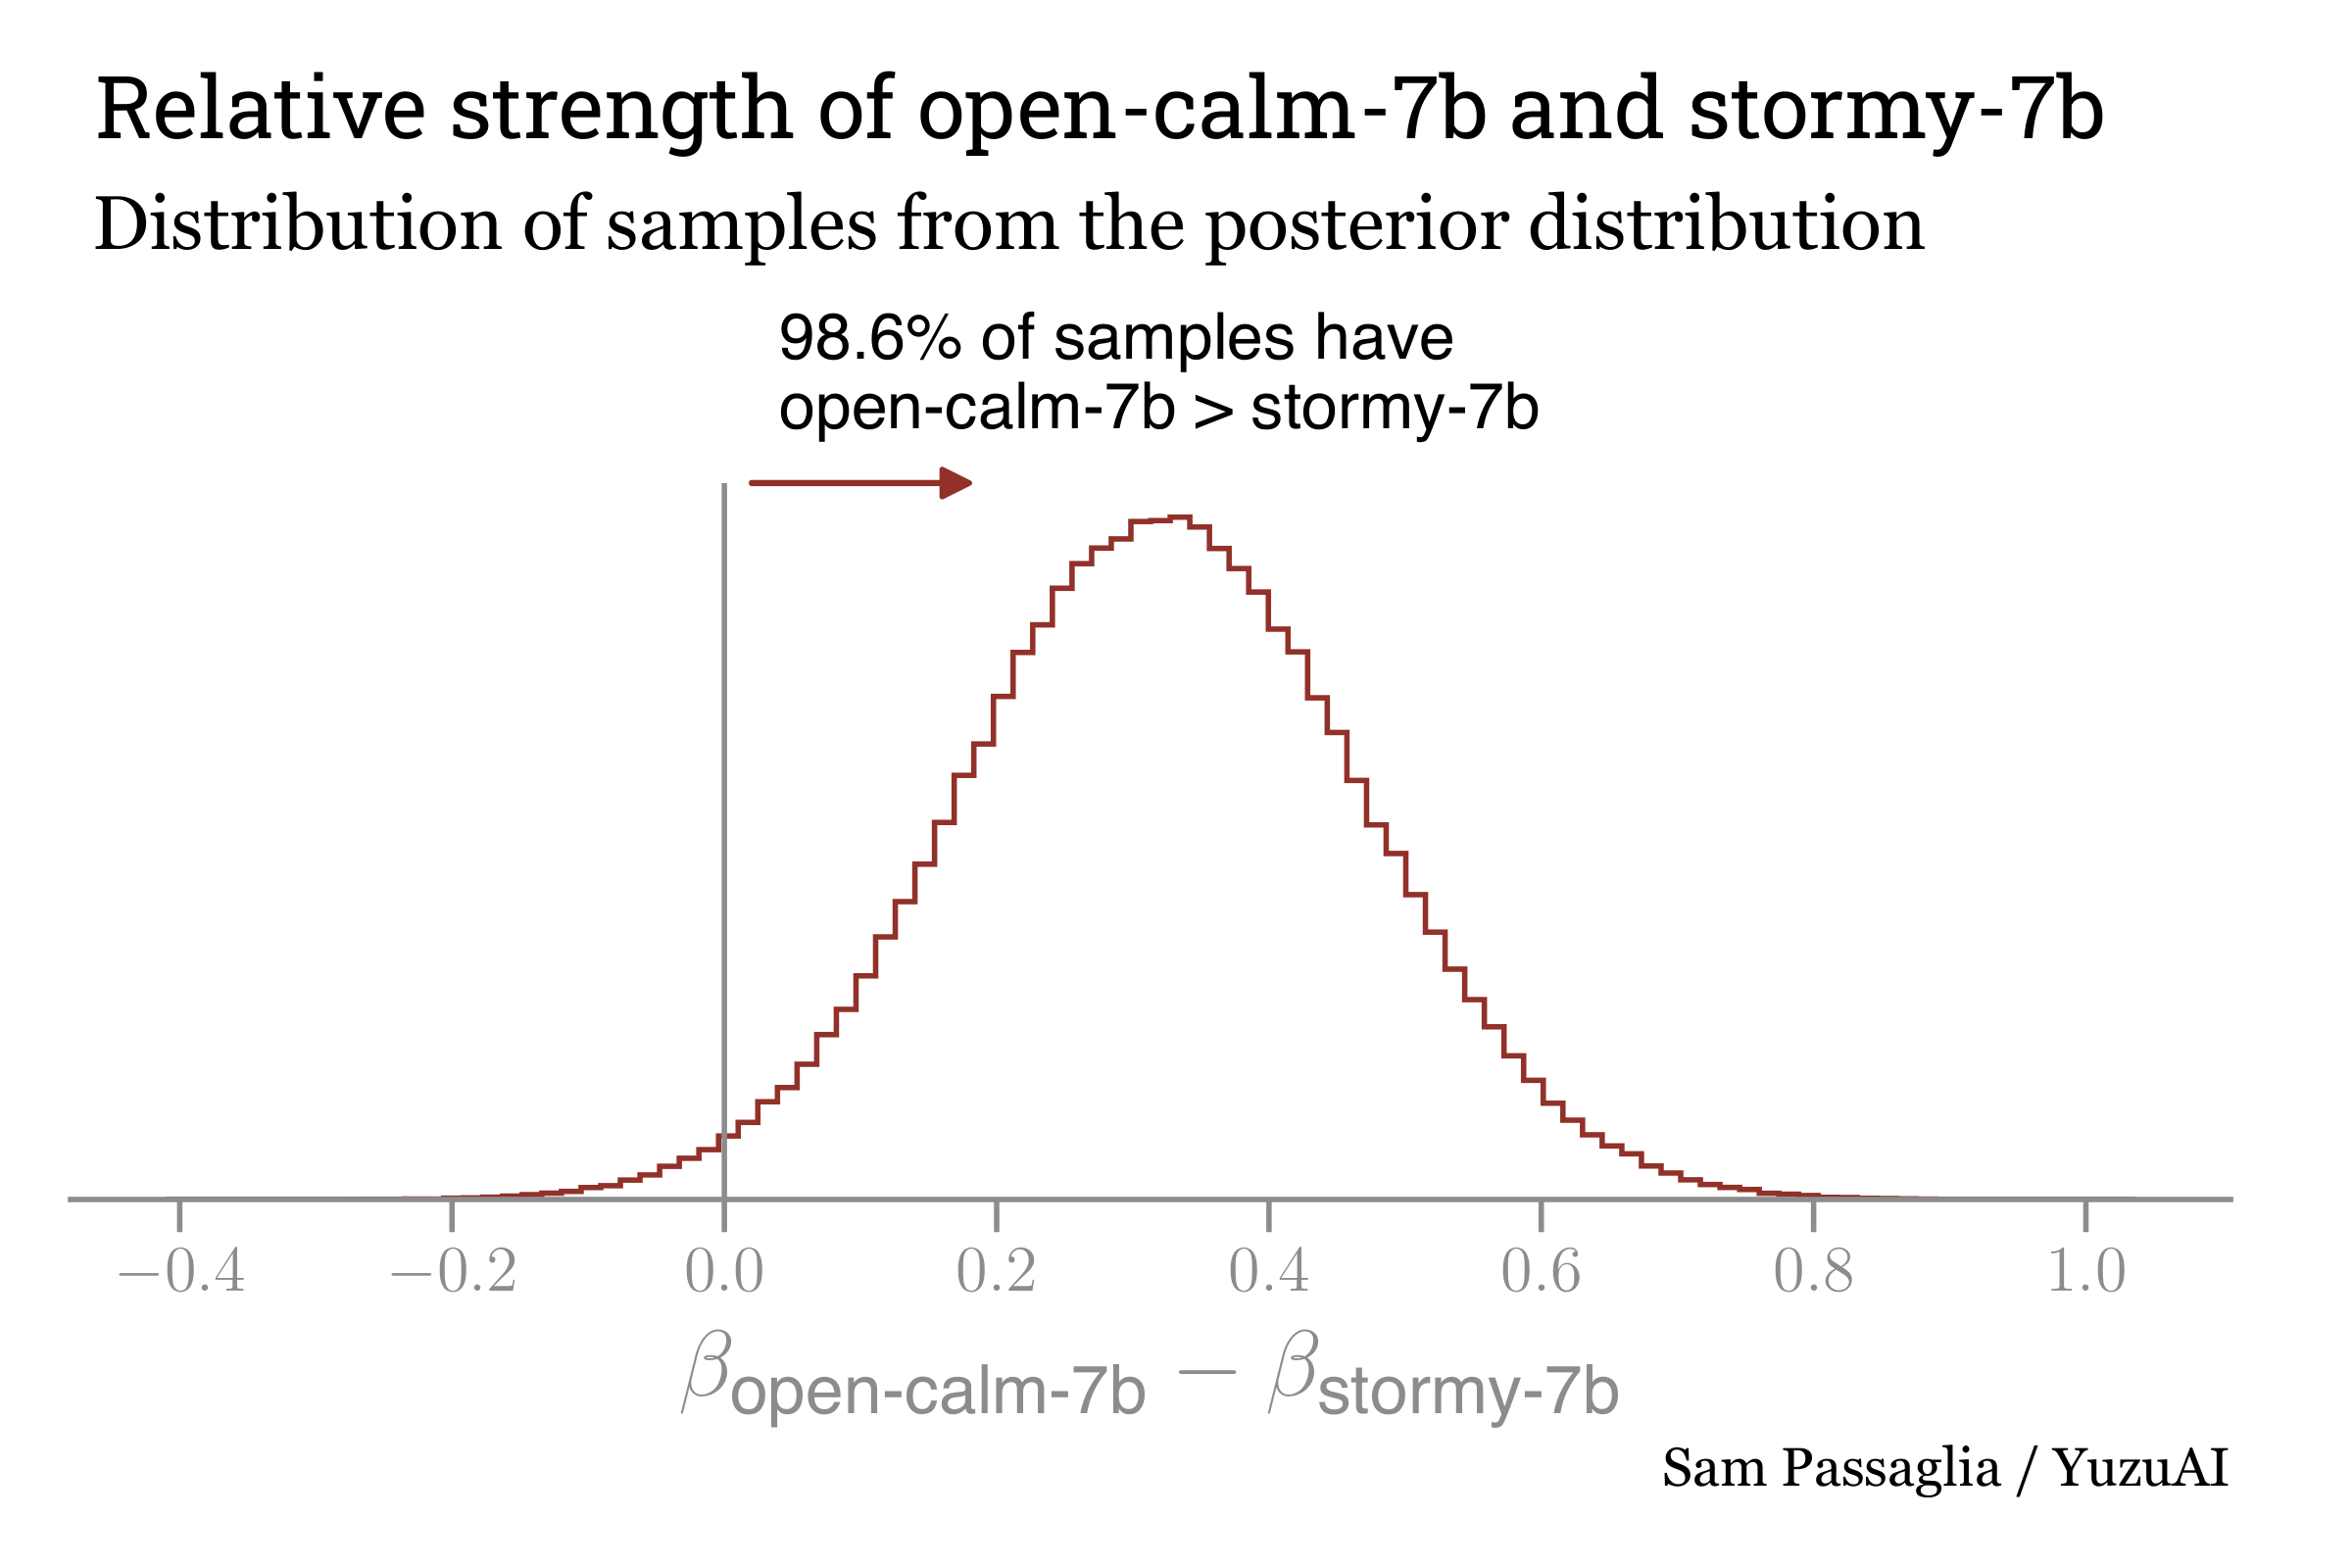

In [42]:
modelA = "cyberagent/open-calm-7b"
modelB = "izumi-lab/stormy-7b-10ep"

diffs = (
    flat_samples[:, model_to_int[modelA] + 1]
    - flat_samples[:, model_to_int[modelB] + 1]
)
shortnameA = short_names[modelA]
shortnameB = short_names[modelB]

A_stronger_rate = np.sum(
    flat_samples[:, model_to_int[modelA] + 1]
    > flat_samples[:, model_to_int[modelB] + 1]
) / len(flat_samples)
print(f"{modelA} is stronger than {modelB} with {A_stronger_rate:.2%} confidence")
# Plot
try:
    from samplotlib import colors
    from samplotlib.circusboy import CircusBoy

    cb = CircusBoy()
    BGColor = "#FFFFFF"
    plt.rcParams["axes.facecolor"] = BGColor
    plt.rcParams["figure.facecolor"] = BGColor
    plt.rcParams["savefig.facecolor"] = BGColor

    fig, ax = cb.handlers()

    hist = ax.hist(diffs, 100, histtype="step")
    ax.set_xlabel(
        rf"${parameter_labels[model_to_int[modelA] + 1]} - {parameter_labels[model_to_int[modelB] + 1]}$",
        size=18,
    )
    arrow_height = 1.0
    ax.annotate(
        "",
        xytext=(0, arrow_height),
        xy=(0.2, arrow_height),
        xycoords=("data", "axes fraction"),
        arrowprops=dict(
            facecolor=hist[2][0]._facecolor[:3],
            edgecolor=hist[2][0]._facecolor[:3],
            width=0.15,
            headlength=5,
            headwidth=5,
            shrink=0.1,
        ),
    )

    ax.annotate(
        f"{A_stronger_rate:.1%} of samples have \n {shortnameA} > {shortnameB}",
        xy=(0.0, arrow_height),
        xycoords=("data", "axes fraction"),
        xytext=(10, 10),
        textcoords="offset points",
    )
    plt.gca().set_yticks([])
    cb.set_byline(ax, "Sam Passaglia / YuzuAI", pad=15)
    ax.axvline(0, color=cb.grey, lw=1)
    cb.set_title(
        ax,
        title=f"Relative strength of {shortnameA} and {shortnameB}",
        subtitle=f"Distribution of samples from the posterior distribution",
        titlesize=16,
        subtitlesize=14,
        pad=40
    )

    fig.savefig(charts_prefix + "diff.png")
    fig.savefig(charts_prefix + "diff.pdf")
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams["text.usetex"] = True

except ImportError:

    plt.close("all")
    plt.figure(figsize=(10, 6))
    plt.hist(
        diffs,
        100,
        color="k",
        histtype="step",
    )
    plt.axvline(0, color="k")
    plt.gca().set_yticks([])
    plt.savefig(charts_prefix + "diff.png")
    # plt.show()

Image(charts_prefix + "diff.png", width=800)

In [29]:
# Do this for all models
for i in range(len(strengths))[::-1]:

    modelA = strengths[i]["model_id"]
    modelB = strengths[i - 1]["model_id"]

    diffs = (
        flat_samples[:, model_to_int[modelA] + 1]
        - flat_samples[:, model_to_int[modelB] + 1]
    )
    shortnameA = short_names[modelA]
    shortnameB = short_names[modelB]

    A_stronger_rate = np.sum(
        flat_samples[:, model_to_int[modelA] + 1]
        > flat_samples[:, model_to_int[modelB] + 1]
    ) / len(flat_samples)
    print(f"{modelA} is stronger than {modelB} with {A_stronger_rate:.2%} confidence")
    strengths[i]["stronger_than_next_confidence"] = A_stronger_rate

    probability_to_beat_next = p(
        0,
        strengths[i]["median"],
        strengths[i - 1]["median"],
    )
    strengths[i]["implied_win_probability"] = probability_to_beat_next

    print(
        f"Fit implies {modelA} wins against {modelB} {probability_to_beat_next:.2%} of the time"
    )
    print(
        f"Measured win probability: {win_frac_ij.iloc[model_to_int[modelA],model_to_int[modelB]]:.2%} "
    )

    if i == 1:
        strengths[0]["stronger_than_next_confidence"] = 0
        strengths[0]["implied_win_probability"] = 0

        break

gpt-3.5-turbo-0301:20230614 is stronger than cyberagent/open-calm-7b with 100.00% confidence
Fit implies gpt-3.5-turbo-0301:20230614 wins against cyberagent/open-calm-7b 92.75% of the time
Measured win probability: 90.00% 
cyberagent/open-calm-7b is stronger than izumi-lab/stormy-7b-10ep with 98.61% confidence
Fit implies cyberagent/open-calm-7b wins against izumi-lab/stormy-7b-10ep 57.95% of the time
Measured win probability: 61.88% 
izumi-lab/stormy-7b-10ep is stronger than rinna/japanese-gpt-neox-3.6b-instruction-ppo with 90.66% confidence
Fit implies izumi-lab/stormy-7b-10ep wins against rinna/japanese-gpt-neox-3.6b-instruction-ppo 54.75% of the time
Measured win probability: 58.75% 
rinna/japanese-gpt-neox-3.6b-instruction-ppo is stronger than rinna/japanese-gpt-neox-3.6b-instruction-sft-v2 with 83.63% confidence
Fit implies rinna/japanese-gpt-neox-3.6b-instruction-ppo wins against rinna/japanese-gpt-neox-3.6b-instruction-sft-v2 53.55% of the time
Measured win probability: 48.12% 

Removed no burn in


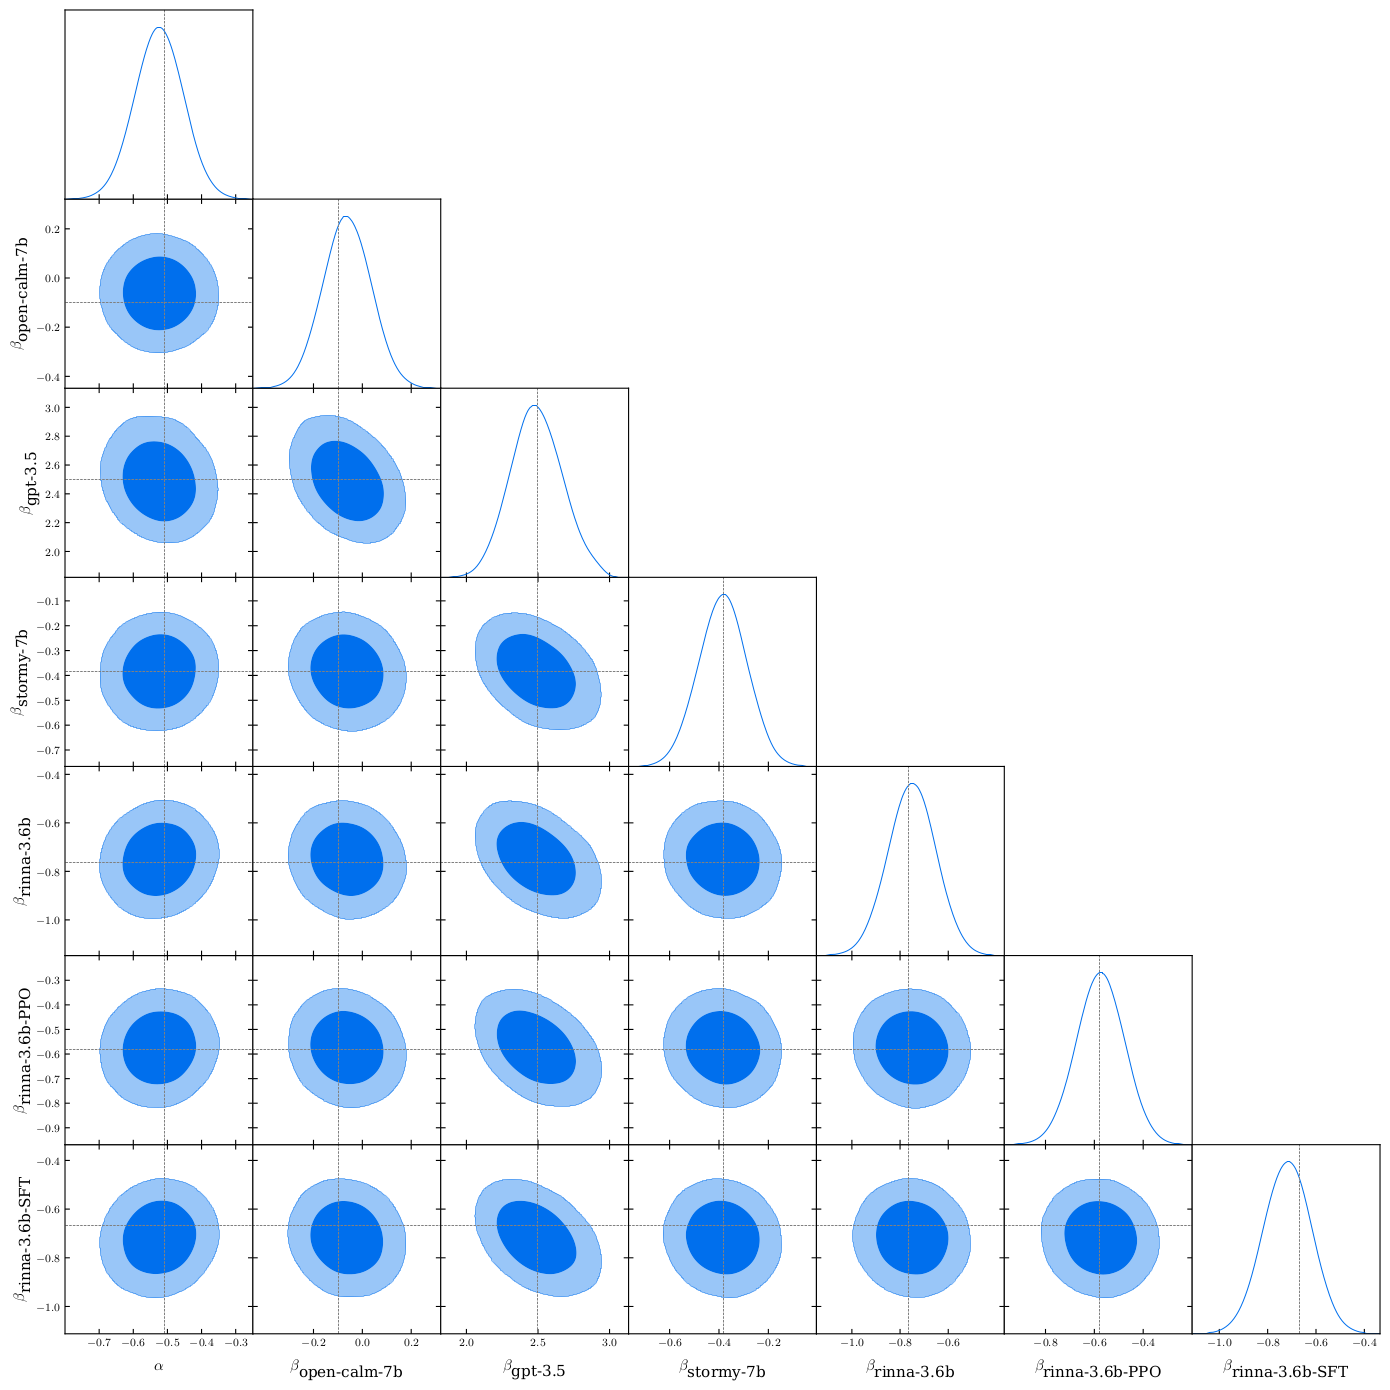

In [30]:
import getdist
from getdist import MCSamples, plots

samples = MCSamples(
    samples=thin_samples, names=parameter_labels_with_dollar
)  # names = names, labels = labels)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True)
# max_likelihood.x[model_to_int[modelA] + 1]
g.add_param_markers(
    {
        parameter_labels_with_dollar[i]: max_likelihood.x[i]
        for i in range(len(parameter_labels_with_dollar))
    }
),
g.export(charts_prefix + "corner_getdist.png")
Image(charts_prefix + "corner_getdist.png", width=1200)

## Output standings and make table

In [31]:
output = {
    "date": tournament["date"],
    "model_metadata": tournament["model_metadata"],
    "metadata": tournament["metadata"],
    "ranking": strengths,
}

In [32]:
strengths

[{'model_id': 'rinna/japanese-gpt-neox-3.6b',
  'short_name': 'rinna-3.6b',
  'median': -0.7498557357907184,
  'one_sigma_down': 0.10003286147865575,
  'one_sigma_up': 0.09884518008352816,
  'win_rate': 0.35125,
  'stronger_than_next_confidence': 0,
  'implied_win_probability': 0},
 {'model_id': 'rinna/japanese-gpt-neox-3.6b-instruction-sft-v2',
  'short_name': 'rinna-3.6b-SFT',
  'median': -0.7168933596306486,
  'one_sigma_down': 0.10067542111435268,
  'one_sigma_up': 0.09883055749410075,
  'win_rate': 0.35875,
  'stronger_than_next_confidence': 0.5896085805084745,
  'implied_win_probability': 0.5082398479914311},
 {'model_id': 'rinna/japanese-gpt-neox-3.6b-instruction-ppo',
  'short_name': 'rinna-3.6b-PPO',
  'median': -0.5746217398838028,
  'one_sigma_down': 0.09908048140279047,
  'one_sigma_up': 0.09771953182688947,
  'win_rate': 0.3925,
  'stronger_than_next_confidence': 0.8363220338983051,
  'implied_win_probability': 0.5355080313279331},
 {'model_id': 'izumi-lab/stormy-7b-10ep',

In [33]:
output_path = f"./rankings/{tournament_file.split('/')[-1].split('.')[0]}.json"

In [34]:
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

In [35]:
from registry import StandingsRegistry

registry = StandingsRegistry("./registry/registry.jsonl")
registry.register(output_path)

In [46]:
import json
import os
from datetime import datetime


def model_hyperlink(link, model_name):
    return f'<a target="_blank" href="{link}" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">{model_name}</a>'


def make_clickable_model(model_name):
    link = f"https://huggingface.co/{model_name}"

    # Can hardcode urls and names here
    if "gpt-3.5-turbo" in model_name:
        link = "https://openai.com/"
        model_name = "GPT-3.5"

    return model_hyperlink(link, model_name)


rankings = sorted(output["ranking"], key=lambda x: x["median"], reverse=True)
table = "| Rank | Model | Strength | Win Rate | Stronger than the next model at confidence level  | \n| :--- | :---: | :---: | :---: | :---: |\n"
for i, rank in enumerate(rankings):
    #assert(round(rank['one_sigma_up'],2) == round(rank['one_sigma_down'],2))
    table += f"| {i+1} | {make_clickable_model(rank['model_id'])} | {rank['median']:.3f} ± {rank['one_sigma_up']:.2f}  | {rank['win_rate']:.0%} | { str(round(rank['stronger_than_next_confidence']*100,1))+'%' if rank['stronger_than_next_confidence']!=0 else 'N/A'}\n"

In [47]:
print(table)
display(Markdown(table))

| Rank | Model | Strength | Win Rate | Stronger than the next model at confidence level  | 
| :--- | :---: | :---: | :---: | :---: |
| 1 | <a target="_blank" href="https://openai.com/" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">GPT-3.5</a> | 2.487 ± 0.19  | 94% | 100.0%
| 2 | <a target="_blank" href="https://huggingface.co/cyberagent/open-calm-7b" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">cyberagent/open-calm-7b</a> | -0.063 ± 0.10  | 52% | 98.6%
| 3 | <a target="_blank" href="https://huggingface.co/izumi-lab/stormy-7b-10ep" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">izumi-lab/stormy-7b-10ep</a> | -0.384 ± 0.10  | 44% | 90.7%
| 4 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b-instruction-ppo" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">rinna/japanese-gpt-neox-3.6b-instruction-ppo</a> | -0.575 ± 0.10  | 39% | 83.6%
| 5 | 

| Rank | Model | Strength | Win Rate | Stronger than the next model at confidence level  | 
| :--- | :---: | :---: | :---: | :---: |
| 1 | <a target="_blank" href="https://openai.com/" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">GPT-3.5</a> | 2.487 ± 0.19  | 94% | 100.0%
| 2 | <a target="_blank" href="https://huggingface.co/cyberagent/open-calm-7b" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">cyberagent/open-calm-7b</a> | -0.063 ± 0.10  | 52% | 98.6%
| 3 | <a target="_blank" href="https://huggingface.co/izumi-lab/stormy-7b-10ep" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">izumi-lab/stormy-7b-10ep</a> | -0.384 ± 0.10  | 44% | 90.7%
| 4 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b-instruction-ppo" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">rinna/japanese-gpt-neox-3.6b-instruction-ppo</a> | -0.575 ± 0.10  | 39% | 83.6%
| 5 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b-instruction-sft-v2" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">rinna/japanese-gpt-neox-3.6b-instruction-sft-v2</a> | -0.717 ± 0.10  | 36% | 59.0%
| 6 | <a target="_blank" href="https://huggingface.co/rinna/japanese-gpt-neox-3.6b" style="color:#1e50a2, textDecoration: underline,textDecorationStyle: dotted">rinna/japanese-gpt-neox-3.6b</a> | -0.750 ± 0.10  | 35% | N/A
